# Feature Visualisation

Sumie is a library for optimising images. 

In particular it is intended for producing viusalisations for neural networks by optmiising and image for a particular response from the network. The classic example of this is to produce an image that maximally activates a particular part of a network, as a way of visualising what features it has learnt.

To get a 'nice' looking image this way isn't as simple as it seems, and lots of people have figure out plenty of tricks to get this to work well (_TODO add refs_) and Sumie implments some of these.

In [1]:
import sumie
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import skimage

%matplotlib inline

### Setting up the network

First we need a pretrained neural network that we want to visualise the features for. Happily torchvision comes with plenty of pretrained models.

In [2]:
model = torchvision.models.vgg16(pretrained=True).eval()
# TODO do we need this?
sumie.utils.remove_inplace(model)

We want to optimise for the mean output of a particular channel from a layer. VGG16 has lots of layer (or modules in PyTorch speak, shown below). Let's pick a particular convolutional layer later on in the network, we pick this my referencing a particular module in the network. A particular convolutional layer has many channels, we need to pick one.

In [3]:
layer = model.features[26]
channel_index = 0

### Making an image

Next we need to make the image that we will optimise. We need to pass in the desired image size, a parameterisation option (here we will use the most straighforward: 'rgb'), and a list of transforms to apply to the image. By default images in sumie are in the range 0 to 1, but models trained on ImageNet expect a normalisation to be applied and sumie supplies a transform to do just this.

Images in Sumie are PyTorch modules that take no inputs. So to get the output pixels (after transformation) we just call the image (which is blank).

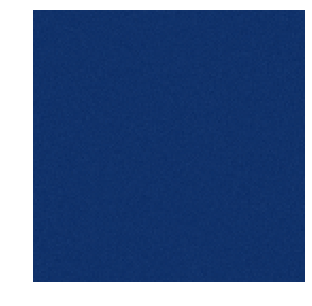

In [4]:
imsize = 128
transforms = [sumie.transforms.Normalise(),]
im = sumie.Image(imsize, param='rgb', transforms=transforms)
sumie.vis.show(im())

The thing that does the optimisation is an Optimiser object, we create one and call the run method to do the optimisation. Afterwards we can use the get_image method to get the values of the untransformed image and display this.

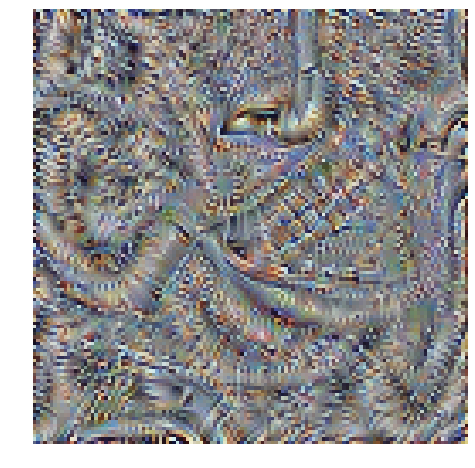

In [5]:

device = 'cpu'
im.to(device)
model.to(device)
channel = sumie.objectives.ConvChannel(layer, channel_index)
opt = sumie.Optimiser(im, model.features, channel)

opt.run(iterations=100, progress=True)
sumie.vis.show(im.get_image(), figsize=(8,8))

Hmm, doesn't look great. This is where we need all the tweaks, let's try again. (TODO)

/home/justin/code/sumie/venv/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


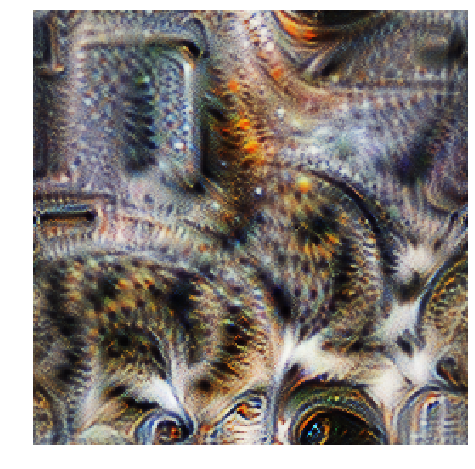

In [6]:
imsize = 256

im = sumie.Image(imsize, param='fft', transforms=[
                    sumie.transforms.PositionJitter(8),
                    sumie.transforms.Interpolate(0.5),
                    sumie.transforms.RotationJitter(0.1),
                    sumie.transforms.PositionJitter(4),
                    sumie.transforms.Normalise(),
              ]
            )

im.to(device)
channel = sumie.objectives.ConvChannel(layer, channel_index)
opt = sumie.Optimiser(im, model.features, channel)

opt.run(iterations=100, progress=True)
sumie.vis.show(im.get_image(), figsize=(8,8))

Much better! Smarter people than me are indeed smart!